This notebook sketches a possible approach to building *smttask* workflows based on Jupyter notebooks, from specifying task dependencies to deploying for computation on a potentially remote machine.

# Set up your environment

You you haven't already, you should get familiar with the *smttask* [workflow concept](../docs/basics.rst).

The reference at the above link will also help you configure your environment. You will need to do so to run the code samples below.

Move to the directory containing the Sumatra project and task definitions.

In [1]:
%cd fft_example

/home/alex/Recherche/macke_lab/code/smttask/examples/fft_example


# Build the workflow
We first open a Jupyter notebook on our local machine and import the packages we need.
> **Tip** Place all your imports in an *init.py* file, to reuse your initialization in different notebooks

In [2]:
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import mackelab_toolbox as mtb
import smttask
from tasks import GenerateData, ProcessData

For the purpose of this tutorial we will disabled recording tasks. This allows tasks to be run without them checking that the repository is clean, but they will not be recorded in the Sumatra database and results will not be written to disk.

In [3]:
smttask.config.record = False

/home/alex/Recherche/macke_lab/code/smttask/smttask/base.py:118: UserWarning: Recording of tasks has been disabled. Task results will not be written to disk and run parameters not stored in the Sumatra databasa.
  warn("Recording of tasks has been disabled. Task results will "


Our toy workflow here consists of generating three different signals, and “processing” them (i.e. computing their discrete Fourier transform).

Tasks are most conveniently defined by decorating a function; the definitions of the tasks used in this example are as follows:

In [4]:
import fft_example.tasks
print("fft_example/tasks.py:")
mtb.utils.Code(fft_example.tasks)

fft_example/tasks.py:


Note that `GenerateData` is an `MemoizedTask` – for cheap random functions like this, generating data from the three parameters `τ`, `σ` and `seed` is often faster than reading it from disk. Not to mention more memory efficient.

> **Important**: Each function argument must have a type annotation, and the return type must also be defined.

> Also good to know: the object returned by the decorator is a subclass of `Task` rather than a function.

We define our workflow by first defining different signals we want to process.

(On my machine this throws a warning; this should be fixed at some point.)

In [5]:
signals = [GenerateData(τ=0.1, σ=0.1, seed=1),
           GenerateData(τ=1, σ=0.1, seed=1),
           GenerateData(τ=10, σ=0.1, seed=1)]

And then how each is processed.

In [6]:
spectra = [ProcessData(x=x) for x in signals]

> Task arguments must be specified with keywords.

At this point we can pick a task and display its dependencies as a graph

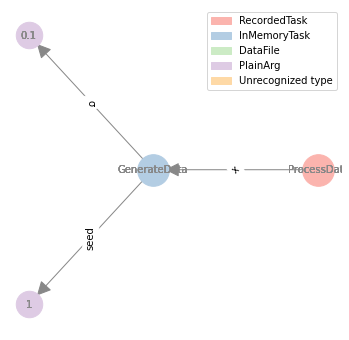

In [7]:
spectra[0].draw(figsize=(6,6))

> Graph colours were chosen to work with both light and dark Jupyter themes. You're welcome ;-)

At this point the workflow is completely defined. Since we haven't run anything yet, workflow definition can easily be done on a local machine with limited resources.

# Run the workflow in the notebook

To run the workflow locally, just execute the `run()` method of the highest-level task.
In our example, each `ProcessData` task will automatically trigger the `GenerateData` task on which it depends.
> If you will reuse in-memory tasks, consider turning on in-memory caching (`smttask.config.cache_runs`). Just be careful not to overflow your system memory.

In [8]:
for S in spectra:
    S.run()

If we hadn't turned off caching, these runs would be saved to disk, and in the cell below loaded from disk instead of re-run.

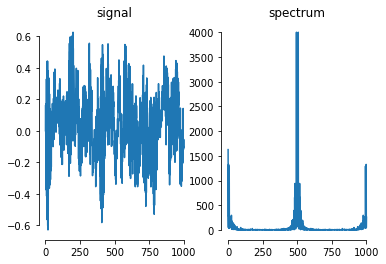

In [9]:
fig, (axx, axS) = plt.subplots(1,2)
axx.plot(signals[2].run());
axS.plot(spectra[2].run()[1]);
sns.despine(ax=axx, trim=True); sns.despine(ax=axS, trim=True)
axx.set_title("signal"); axS.set_title("spectrum");

# Run the task in a shell

If you have many tasks to run, you will want to do that in a shell, possibly through a scheduler like [Snakemake](https://snakemake.readthedocs.io), and possibly on a remote machine.

To do this, export your workflow by calling a task's `save()` method. You only need to this on the highest level task; dependencies will automatically be included.

> Note that to run multiple tasks in parallel, they need to be defined (saved) and run separately. *smttask* provides no scheduling capabilities.

In [10]:
S.digest

'9618a6841303dd8ba91bdcba4d2d9dd6acdb3c1d'

In [11]:
for S in spectra:
    S.save(f"process-task_{S.digest[:4]}")

After executing the cell above, you should have three task description files in your current directory:

In [12]:
%ls process-task_*

process-task_1cb8.taskdesc  process-task_9618.taskdesc
process-task_1d2a.taskdesc  process-task_ae32.taskdesc
process-task_297b.taskdesc  process-task_e8a2.taskdesc


The `save()` method stores a complete definition of the task in a `taskdesc` format (a JSON file with specified schema).

In [13]:
print(repr(S.desc))
print("\nJSON representation:\n", S.desc.json())
#print("\nJSON schema:\n", smttask.base.TaskDesc.schema())

TaskDesc(taskname='ProcessData', module='tasks', inputs=Inputs(x=GenerateData(τ=10.0, σ=0.1, seed=1)))

JSON representation:
 {"taskname": "ProcessData", "module": "tasks", "inputs": {"x": {"taskname": "GenerateData", "module": "tasks", "inputs": {"\u03c4": 10.0, "\u03c3": 0.1, "seed": 1}}}}


To run a task in a shell, activate the same environment you used to create the workflow. Then use *smttask*'s command-line interface to run the `taskdesc` file:

```
$ smttask run process-task_34d5.taskdesc
```

> **Remark** The line above assumes that the Sumatra project is part of a package (i.e. something pip-installable). This is generally good practice, and allows project code to be run from anywhere, as long as the package is installed.
> If tasks are not part of an installed package, you need to amend the `PYTHONPATH` so that `smttask` can find them.
>  ```
>  $ PYTHONPATH=. smttask run process-task_34d5.taskdesc
>  ```
> \
> The value assigned to `PYTHONPATH` should be the directory which was current when *process-task_34d5.taskdesc* was created.

The command line interface provides a few flags to set the logging level and trigger the debugger.

```
$ smttask run --help
Usage: smttask run [OPTIONS] TASKDESC

  Execute the Task defined in TASKDESC.

  A taskdesc can be obtained by calling `.desc.save()` on an instantiated
  task."

Options:
  --record / --no-record  Use `--no-record` to disable recording (and thereby
                          also the check that the version control repository
                          is clean).

  -v, --verbose           Specify up to 3 times (`-vvv`) to increase the
                          logging level which is printed. Default is to print
                          only warning and error messages.
                          default: warning and up (error, critical)
                          -v: info and up
                          -vv: debug and up
                          -vvv: everything.

  -q, --quiet             Turn off warning messages. Specifying multiple times
                          will also turn off error and critical messages.

  --debug / --no-debug    Launch the debugger before running task.
  --help                  Show this message and exit.
```

## Running on a remote machine

Running on a remote machine is as simple as copying the `taskdesc` file to that machine, running `smttask run [taskdesc]` as above, and copying the results back to the local machine.

It is easiest if the environment on the remote environment mirrors, both in terms of the installed packages and the directory structure. To mirror packages, use either
```python
    conda env export
```
or
```python
    pip freeze > requirements.txt
```
To mirror the directory structure, you can of course use `scp` or `rsync`. For a more convenient setup, you may consider [Unison](https://www.cis.upenn.edu/~bcpierce/unison/) both to copy `taskdesc` files onto the remote, and to copy the results back to your machine. *Unison* will only copy new or modified files, so it is friendly to your bandwidth.